# JWST AMI Optical Simulations using dLuxWebbPSF

In this notebook I will work show the most basic example of how to use `dLuxWebbPSF` to simulate the AMI point spread function. The model presented here matches the model PSF generated by `WebbPSF` to within machine precision, including detector distortion effects. Additionally, it has the capability to generate Hexike aberrations over each individual mirror segment. And of course, all the code is differentiable, so we can use it for inference!

First, let's import relevant packages.

In [215]:
# jax
import jax.numpy as np
import jax.random as jr

# optical simulation
import webbpsf

# differentiable optical simulation
import dLux as dl
from dLux.utils import deg_to_rad as d2r
import dLuxWebbpsf as dlW

# visualisation
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'

Here we generate the `WebbPSF` NIRISS optical system (e.g. transmission, OPD map), which we feed to `dLuxWebbpsf` to perform the differentiable simulation. We also grab the NIS_CEN aperture from the SIAF, which we will use to implement the detector distortion.

In [117]:
# For AMI
webbpsf = webbpsf.NIRISS()  # WebbPSF instrument
webbpsf.pupil_mask = "MASK_NRM" # applies the NRM mask -- remove this line for full pupil simulation
webbpsf.calc_psf()
NIS_CEN_aperture = webbpsf.siaf.apertures["NIS_CEN"]  # grabbing the aperture object from the SIAF
webbpsf_osys = webbpsf.get_optical_system()
planes = webbpsf_osys.planes  # [Linear Model WSS, Coord inversion, FDA, NRM, Detector]

primary_plane = planes[0]  # WebbPSF plane object, initial plane at primary
pupil_plane = planes[-2]  # WebbPSF plane object, NRM mask plane

Alright, let's define the parameters of the simulation.

First, we will generate some random Hexike coefficients for each mirror segment; we will generate coefficients for the first three radial orders (i.e. piston, tip, tilt, defocus, astigmatism, coma).

We will also define the flux of the point source, the filter, and we will grab the pixel scale of the detector from `WebbPSF`.

In [118]:
# Hexike coefficients
def coeffs_shape(n_mirrors: int):
    return n_mirrors, int(np.sum(np.array(
        [dl.utils.triangular_number(i + 1) - dl.utils.triangular_number(i) for i in radial_orders]
    )))

radial_orders = np.array([0, 1, 2], dtype=int)
hexike_coeffs = 1e-7 * jr.normal(jr.PRNGKey(0), coeffs_shape(7))

# Flux of the image
flux = 1e6

# filter -- compatible with F380M, F430M, F480M
filter_name = "F480M"

# Image parameters
npix = 1024  # pixels
oversample = 4
pscale = planes[-1].pixelscale.to("arcsec/pix").value  # arcsec/pix, grabbing pixel scale from detector plane

Finally, we build the `dLux`-based machinery for the simulation.

First we build a `Source` object, which is a point source with a spectral flux distribution based on the F480M filter. 

We next build the `Optics` object, which represents the full optical system of NIRISS. This includes:
- the aberrated primary mirror
- a y-coordinate inversion
- the NRM mask
- a Fourier transform propagation to the image plane

We then build the `Detector` object, which implements the detector effects. This includes:
- a half-degree rotation to the detector frame
- the detector distortion based on the SIAF
- downsampling to the detector pixel scale
- (if we wanted to add telescope jitter, we would add it here)
- (if we wanted to model the Brighter-Fatter effect, we would add it here)

Finally, we collate the `Source`, `Optics`, and `Detector` objects into an `Instrument` object, which stores all this information in a single PyTree. I will create one instrument which is ignorant of detector effects, so we can see an over-sampled PSF, and one instrument which includes detector effects, so we can see the final PSF.

In [119]:
# building a point source with the spectral flux distribution of the given filter
src = dl.PointSource(flux=flux, **dict(np.load(f"filter_configs/{filter_name}.npz")))

# building the optical system for AMI
osys = dl.LayeredOptics(
    wf_npixels=1024,
    diameter=primary_plane.pixelscale.to("m/pix").value * primary_plane.npix,
    layers=[
        (dlW.JWSTAberratedPrimary(
            primary_plane.amplitude,
            primary_plane.opd,
            radial_orders=radial_orders,
            coefficients=hexike_coeffs,
            AMI=True,  # FALSE FOR FULL PUPIL
        ), "Pupil"),
        (dl.Flip(0), "InvertY"),
        (dl.Optic(pupil_plane.amplitude), "Mask"),
        (dlW.MFT(npixels=oversample * 64, oversample=oversample, pixel_scale=pscale), "Propagator"),
    ]
)

# building the detector, implementing rotation and distortion
detector = dl.LayeredDetector(
    [
        dlW.detector_layers.Rotate(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),
        dlW.DistortionFromSiaf(instrument=webbpsf, optics=webbpsf_osys),
        dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    ]
)

# collating into dLux instrument
oversampled_instrument = dl.Instrument(sources=[src], optics=osys, detector=None)
instrument = dl.Instrument(sources=[src], optics=osys, detector=detector)

To generate the PSF, we simply call the `.model()` method of the `Instrument` object. That's it!

In [120]:
oversampled_psf = oversampled_instrument.model()  # generating the oversampled PSF image
psf = instrument.model()  # generating the final PSF image

Let's have a look at our final PSF.

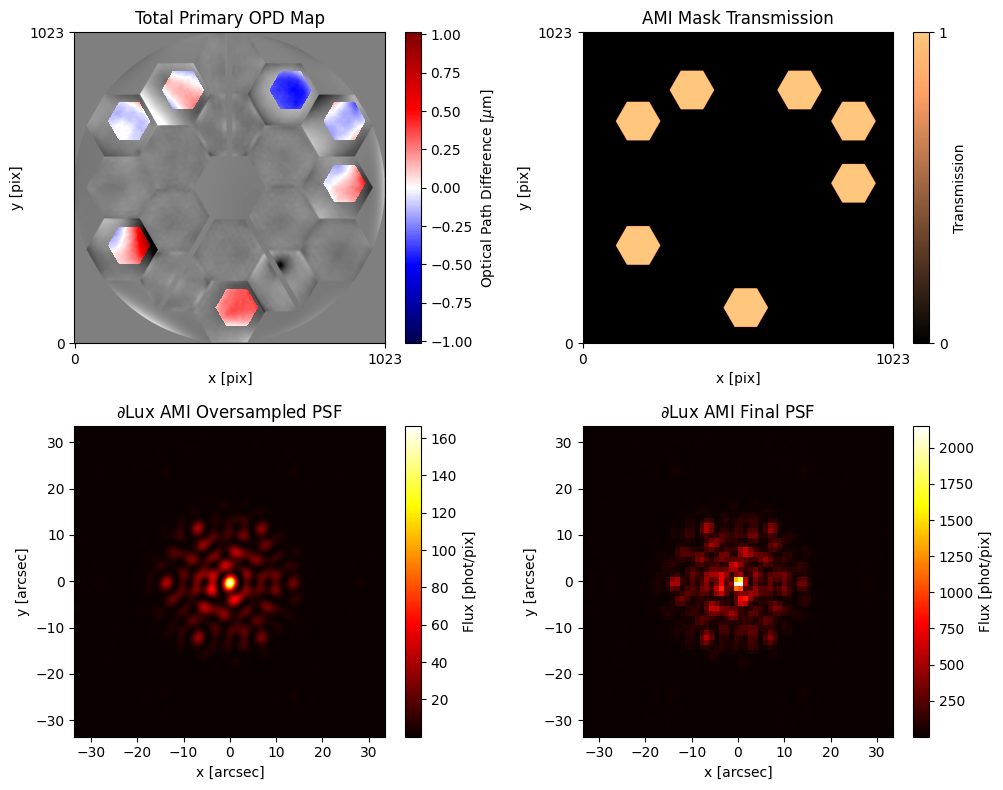

In [216]:
transmission = np.flip(pupil_plane.amplitude, axis=0)  # NRM Transmission array, with y-axis flip
total_opd = 1e6*(osys.Pupil.basis_opd + primary_plane.opd)  # in nm
t_mask = transmission.at[transmission < 1e-8]  # mask for cmaps
ext = np.array([np.max(total_opd*t_mask.set(0)), np.abs(np.min(total_opd*t_mask.set(0)))]).max()  # cmap extent
ticks = [0, total_opd.shape[0]-1]  # ticks for the pixel grids

# Plotting code
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10.2, 8))
# opd map
ax0.imshow(total_opd, cmap='binary', vmin=-ext, vmax=ext)
c0 = ax0.imshow(total_opd*t_mask.set(np.nan), cmap='seismic', vmin=-ext, vmax=ext)
ax0.set(title="Total Primary OPD Map", xlabel="x [pix]", ylabel="y [pix]", xticks=ticks, yticks=ticks)
fig.colorbar(c0, label='Optical Path Difference [$\mu$m]')

# transmission
c1 = ax1.imshow(np.flip(pupil_plane.amplitude, axis=0), cmap='copper')
ax1.set(title="AMI Mask Transmission", xlabel="x [pix]", ylabel="y [pix]", xticks=ticks, yticks=ticks)
fig.colorbar(c1, label="Transmission", ticks=[0, 1])

# oversampled point spread function
c2 = ax2.imshow(oversampled_psf, cmap='hot', extent=np.array([-1, 1, -1, 1]) * pscale * npix / 2,)
ax2.set(title="$\partial$Lux AMI Oversampled PSF", xlabel="x [arcsec]", ylabel="y [arcsec]")
fig.colorbar(c2, label='Flux [phot/pix]')

# point spread function at the detector
c3 = ax3.imshow(psf, cmap='hot', extent=np.array([-1, 1, -1, 1]) * pscale * npix / 2,)
ax3.set(title="$\partial$Lux AMI Final PSF", xlabel="x [arcsec]", ylabel="y [arcsec]")
fig.colorbar(c3, label='Flux [phot/pix]')

plt.tight_layout()
plt.savefig("figures/5cells_img.pdf", dpi=300, bbox_inches='tight')
plt.show()

Contributors: Max Charles, Louis Desdoigts, Irina Troitskaya, Benjamin Pope, Peter Tuthill